## All sky proper motion map for Gaia EDR3

This notebook demonstrates the use of the combination of the Gaia archive and python tools to create an all-sky map of the average proper motion of stars, calculated per Healpix pixel, and plotted as vectors on a sky map.

### Creating the map data with and ADQL query

Following the example on the [Gaia archive help pages](http://gea.esac.esa.int/archive-help/adql/examples/index.html) (look for "TGAS Healpix maps") I used the following query to extract avarages of the astrometric parameters of all sources at $12\leq G\leq14$, binned at Healpix level 4:
```
SELECT
  gaia_healpix_index(4, source_id) AS healpix_4,
  count(*) / 13.4286983 as sources_per_sq_deg,
  avg(parallax) as avg_parallax,
  avg(pmra) AS avg_pmra,
  avg(pmdec) AS avg_pmdec,
  avg(ra_error) AS avg_ra_error,
  avg(dec_error) AS avg_dec_error,
  avg(parallax_error) AS avg_parallax_error,
  avg(pmra_error) AS avg_pmra_error,
  avg(pmdec_error) AS avg_pmdec_error,
  avg(ra_dec_corr) AS avg_ra_dec_corr,
  avg(ra_parallax_corr) AS avg_ra_parallax_corr,
  avg(ra_pmra_corr) AS avg_ra_pmra_corr,
  avg(ra_pmdec_corr) AS avg_ra_pmdec_corr,
  avg(dec_parallax_corr) AS avg_dec_parallax_corr,
  avg(dec_pmra_corr) AS avg_dec_pmra_corr,
  avg(dec_pmdec_corr) AS avg_dec_pmdec_corr,
  avg(parallax_pmra_corr) AS avg_parallax_pmra_corr,
  avg(parallax_pmdec_corr) AS avg_parallax_pmdec_corr,
  avg(pmra_pmdec_corr) AS avg_pmra_pmdec_corr
FROM user_edr3int4.gaia_source
where phot_g_mean_mag between 12 and 14
GROUP BY healpix_4
```
This query runs very fast (30-40 seconds) and provides easy access to such statistics without having to download the data. The number in the ```count(*)...``` line is the number of square degrees covered by a Healpix pixel, given by

\begin{equation}
  \Omega_\mathrm{pixel} = \frac{360^2}{\pi}\times\frac{1}{12\times 2^{2k}}\,,
\end{equation}

where $k$ is the Healpix level (or order, or depth, with $N_\mathrm{side}=2^k$) and the area is in units of degree$^2$.

The following code shows how to read in the VO table resulting from the query above and how to make a source density map overlaid with the average proper motions by using matplotlib and the [healpy](https://healpy.readthedocs.io/en/latest/index.html) and [cartopy](http://scitools.org.uk/cartopy/) tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import healpy as hp
from astropy.coordinates import ICRS, Galactic
from astropy.table import Table
import astropy.units as u
from matplotlib.patches import ArrowStyle

/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a 

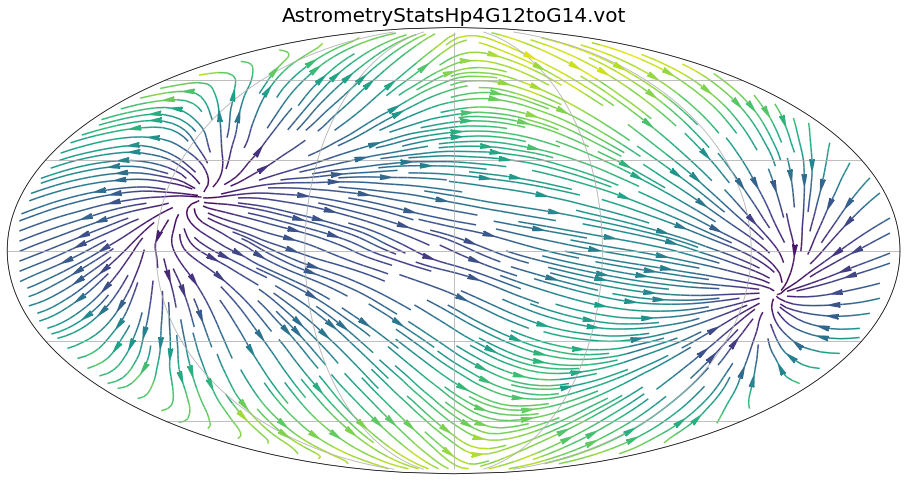

In [8]:
defaultProj = ccrs.PlateCarree()
skyProj = ccrs.Mollweide()

hplevel=4
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpcol = 'healpix_{0}'.format(hplevel)
fileName = "AstrometryStatsHp{0}G12toG14.vot".format(hplevel)
edr3data = Table.read(fileName, format='votable')

hpmap = np.zeros(npix)
hpmap[:] = hp.pixelfunc.UNSEEN
hpmap[edr3data[hpcol]] = edr3data['sources_per_sq_deg']
maskedMap=hp.pixelfunc.ma(hpmap)
hpsourcemap = hp.visufunc.cartview(maskedMap, coord=['C','G'], nest=True, title='', 
                             unit='[deg$^{-2}$]', cbar=False, notext=True,
                             return_projected_map=True, flip='geo')
plt.close()

hplevel=4
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpcol = 'healpix_{0}'.format(hplevel)
fileName = "AstrometryStatsHp{0}G12toG14.vot".format(hplevel)
edr3data = parse(fileName, pedantic=False).get_first_table().to_table(use_names_over_ids=True)

alpha, delta = hp.pix2ang(nside, edr3data[hpcol], lonlat=True, nest=True)
pmra = edr3data['avg_pmra']
pmdec = edr3data['avg_pmdec']

icrs = ICRS(ra=alpha*u.degree, dec=delta*u.degree, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr)
galactic = icrs.transform_to(Galactic)

hpmap = np.zeros(npix)
hpmap[:] = hp.pixelfunc.UNSEEN
hpmap[edr3data[hpcol]] = galactic.pm_l_cosb.value
maskedMap=hp.pixelfunc.ma(hpmap)

hppmlmap = hp.visufunc.cartview(maskedMap, coord=['C','G'], nest=True, title='', 
                             unit='[mas/yr]', cbar=False, notext=True, 
                             return_projected_map=True, flip='geo')
plt.close()

hpmap = np.zeros(npix)
hpmap[:] = hp.pixelfunc.UNSEEN
hpmap[edr3data[hpcol]] = galactic.pm_b.value
maskedMap=hp.pixelfunc.ma(hpmap)

hppmbmap = hp.visufunc.cartview(maskedMap, coord=['C','G'], nest=True, title='', 
                             unit='[mas/yr]', cbar=False, notext=True, 
                             return_projected_map=True, flip='geo')
plt.close()

fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(111, projection=skyProj)
#ax.imshow(hpsourcemap, transform=defaultProj, cmap=cm.gist_gray_r, norm=LogNorm(), zorder=-1)
ax.invert_xaxis()
magnitude = (galactic.pm_l_cosb.value ** 2 + galactic.pm_b.value ** 2) ** 0.5
ax.streamplot(galactic.l.value, galactic.b.value, galactic.pm_l_cosb.value, galactic.pm_b.value,
          transform=defaultProj, linewidth=1.5, density=3, color=magnitude, maxlength=0.5, arrowsize=1,
              arrowstyle=ArrowStyle.Fancy(head_length=1.0, head_width=.4, tail_width=.4))
ax.gridlines()
ax.set_title(fileName, loc='center', fontsize=20)

plt.savefig('EDR3ProperMotionsAllSky.png')
plt.show()